# Melgram layer test code

In [16]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import melgram
import librosa
import keras
print keras.__version__
print keras.backend._BACKEND, keras.backend.image_dim_ordering()


1.1.1
theano tf


## Load audio signal

In [17]:
SR = 12000 # sampling rate
duration = 8.0
len_src = int(SR * duration)

src, sr = librosa.load('src/bensound-cute.mp3', sr=12000, duration=8.0)  # whole signal    
src = src[:duration*SR]

n_fft = 512
n_dft = n_fft
n_hop = 256
n_mels = 96

/Users/gnu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Compute melgram using librosa

In [18]:
D = librosa.logamplitude(librosa.feature.melspectrogram(src, 
                                                        n_fft=n_fft, 
                                                        hop_length=n_hop,
                                                        n_mels=n_mels,
                                                        fmax=6000,
                                                        sr=SR), 
                         ref_power=np.max)
print '(n_mel, n_time) = ', D.shape
print 'Librosa Melgram dynamic range is [%4.2f, %4.2f]' % (np.min(D), np.max(D))

(n_mel, n_time) =  (96, 376)
Librosa Melgram dynamic range is [-80.00, 0.00]


## Compute melgram using keras-melspectrogram

In [7]:
src_input = src[np.newaxis, :, np.newaxis]
print 'Input shape for keras-melgram', src_input.shape

melgram_model = melgram.Melspectrogram(n_dft=n_fft, 
                                       input_shape=(len_src, 1), 
                                       trainable=False,
                                       n_hop=n_hop, 
                                       sr=SR,
                                       n_mels=n_mels,
                                       fmax=6000)
output = melgram_model.predict(src_input, batch_size=2)
if keras.backend.image_dim_ordering() == 'th':
    print 'Output shape: (n_data_sample, n_mel, n_time, n_channel)', output.shape
    print '              if it was "tf", (n_data_sample, n_mel, n_time, n_channel)',
elif keras.backend.image_dim_ordering() == 'tf':
    print 'Output shape: (n_data_sample, n_mel, n_time, n_channel)', output.shape
    print '              if it was "th", (n_data_sample, n_channel, n_mel, n_time)\n',    

print 'Keras-melgram dynanic range is [%4.2f, %4.2f]' % (np.min(output), np.max(output))

Input shape for keras-melgram (1, 96000, 1)
Output shape: (n_data_sample, n_mel, n_time, n_channel) (1, 96, 375, 1)
              if it was "th", (n_data_sample, n_channel, n_mel, n_time)
Keras-melgram dynanic range is [-80.00, 0.00]


## Plot them to compare

(96, 376)
(1, 96, 375, 1)


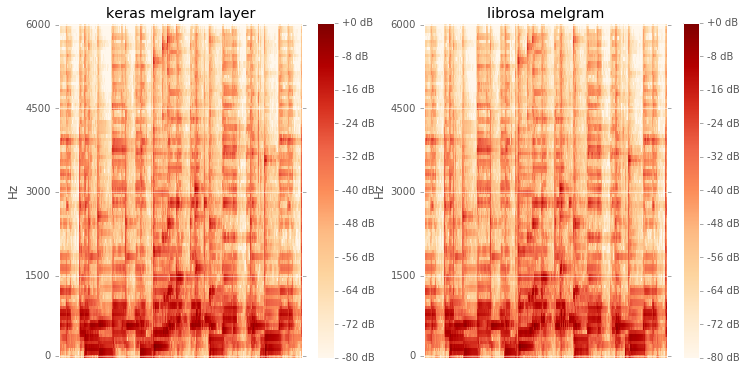

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
if keras.backend.image_dim_ordering() == 'th':
    librosa.display.specshow(output[0, 0, :, :], y_axis='linear', sr=SR, fmax=3000, hop_length=n_hop)
else:
    librosa.display.specshow(output[0, :, :, 0], y_axis='linear', sr=SR, fmax=3000, hop_length=n_hop)
plt.colorbar(format='%+2.0f dB')
plt.title('keras melgram layer')
plt.subplot(1,2,2)
librosa.display.specshow(D, y_axis='linear', sr=SR, fmax=3000, hop_length=n_hop)
plt.colorbar(format='%+2.0f dB')
plt.title('librosa melgram')

print D.shape
print output.shape

## Compare the average (over time) energy patterns

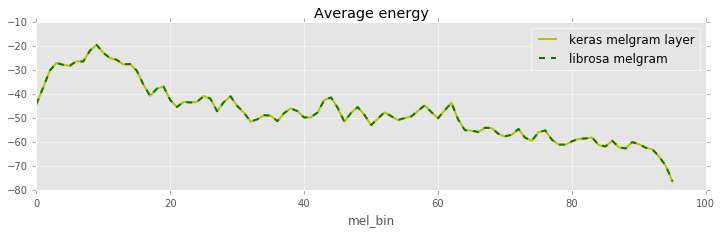

In [15]:
plt.figure(figsize=(12, 3))
if keras.backend.image_dim_ordering() == 'th':
    plt.plot(np.mean(output[0, 0, :, :], axis=1), 'y', linewidth=2, label='keras melgram layer')
else:
    plt.plot(np.mean(output[0, :, :, 0], axis=1), 'y', linewidth=2, label='keras melgram layer')
plt.plot(np.mean(D, axis=1), 'g--', linewidth=2, label='librosa melgram')
plt.xlabel('mel_bin')
plt.title('Average energy')
plt.legend()